In [2]:
import os
import cv2

from dataset_process import dataset_to_df, search_df
from engine import train_fn , eval_fn

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.io import read_image

import albumentations as alb

from torchinfo import summary

from einops import rearrange

from typing import Optional, Tuple


In [2]:
# np.random.seed(0)
# torch.manual_seed(0)

In [3]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


#### Gather all the data from the "CIFAK" dataset to be used later

In [4]:
path = '../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

# path = '../../data/meso_data'
# relative_paths= ["/Real", "/DeepFake"]
# paths_classes=['REAL',"FAKE"]

In [5]:
df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(
    path, relative_paths, paths_classes, 0.8, 0.19, 0.01)

classes_stats

,REAL,FAKE,Total
Training,48000,48000,96000
Validation,11400,11400,22800
Testing,600,600,1200
Row_Total,60000,60000,120000


In [6]:
print("First and Last Elements in the Whole dataset")
df_all.iloc[[0,-1]]
# print(df_all.iloc[[0,-1]].to_markdown(headers='keys', tablefmt='psql'))
# print("")
# print("First and Last Elements in the Training dataset")
# print(df_train.iloc[[0,-1]].to_markdown(headers='keys', tablefmt='psql'))

First and Last Elements in the Whole dataset


,Image_path,Image_size,Class,Class_Codes,Class_Onehot
0,../../data/CIFAK//train/REAL/0000(10).jpg,"(3, 32, 32)",REAL,1,"[1, 0]"
119999,../../data/CIFAK//test/FAKE/999.jpg,"(3, 32, 32)",FAKE,0,"[0, 1]"


#### Determine the number of slices (patches) of the image

In [7]:
Img_horizontal_slices= 4
images_batch = 16

In [8]:
img_shape = read_image(df_all.iloc[0, 0]).size()

slice_width = img_shape[1]//Img_horizontal_slices
total_img_slices = Img_horizontal_slices**2

print(f"slice_width: {slice_width} pixels")
print("")
print("Image shape: ", img_shape)
print(
    f"Image will be divided into: {Img_horizontal_slices} x {Img_horizontal_slices} = {total_img_slices} slices each with shape {(img_shape[0],slice_width,slice_width)}")
print(
    f"Target Shape of the final flattened image: {total_img_slices} x {img_shape[0]*slice_width**2} ")
print("")
print(f"Feed ({images_batch}) Images to the Dataloader")

slice_width: 8 pixels

Image shape:  torch.Size([3, 32, 32])
Image will be divided into: 4 x 4 = 16 slices each with shape (3, 8, 8)
Target Shape of the final flattened image: 16 x 192 

Feed (16) Images to the Dataloader


In [9]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # c: color channels

        # h: desired slice height (pixels)
        # w: desired slice width (pixels)

        # row: No. of vertical slices
        # col: No. of horizontal slices

        # b: Batch of Images

        sliced_Img = rearrange(
            img, 'c (row h) (col w) -> row col c h w', h=slice_width, w=slice_width)

        return sliced_Img

    def __call__(self, img):
        sliced_img = self.slice(img)
        sliced_flattened_img = rearrange(
            sliced_img, 'row col c h w -> (row col) (c h w)')

        return sliced_flattened_img

    plt.show()

In [ ]:
norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [10]:
# Define the transforms on the input data (x) tensor
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((64, 64)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    SliceImage(slice_width=slice_width)
])

In [ ]:
data_transform = alb.Compose(
    [
        To
        alb.Resize(config.image_height, config.image_width, always_apply=True),
        alb.Normalize(norm_mean , norm_std, always_apply=True)
    ])


In [11]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):
        
        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):
        
        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(self.annotation.iloc[index, 4], dtype=torch.float64)

        if self.transform:
            img_t = self.transform(img)

        return img, img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [12]:
# Define the dataset object and configure the Data Loader

Im_tr_dataset = Images_Dataset(df_train, data_transform)

Im_tr_loader = DataLoader(dataset=Im_tr_dataset,
                          batch_size=images_batch,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


Im_val_dataset = Images_Dataset(df_val, data_transform)

Im_val_loader = DataLoader(dataset=Im_val_dataset,
                          batch_size=images_batch,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

#### Plot the original Image and the slices Image

In [13]:
def img_data(Img_train_loader, index):

    img, img_t, label = Img_train_loader.dataset[index]

    channels, img_size,_ = img.size()

    img_slices, slice_flatsize = img_t.size()

    imgs_per_batch = Im_tr_loader.batch_size

    slice_width = int(np.sqrt(slice_flatsize/channels))

    return img, img_t, label, channels, img_size, slice_width, img_slices, slice_flatsize, imgs_per_batch

In [14]:
def img_plot(img, slice_width):
    slice = SliceImage(slice_width)
    sliced_img = slice.slice(img)
    print("Sliced Image Shape: ", sliced_img.shape)

    fig = plt.figure(layout="constrained", figsize=(8, 4))
    subfigs = fig.subfigures(3, 1, height_ratios=[1., 1.5, 1.], hspace=0.05, squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    axs0.imshow(rearrange(img, "c h w -> h w c"))
    axs0.axis('off')
    # subfigs[0].suptitle('Input Image', fontsize=10)

    grid1 = ImageGrid(subfigs[1], 111, nrows_ncols=(
        sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid1):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = rearrange(sliced_img[row][column], "c h w -> h w c").numpy()
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[1].suptitle('Slices', fontsize=10)

    grid2 = ImageGrid(subfigs[2], 111, nrows_ncols=(
        1, sliced_img.size(0)*sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid2):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[2].suptitle('Position', fontsize=10)

In [15]:
_, sample_img_batch,_ = next(iter(Im_tr_loader))

print(f"Batch of Images Shape: {sample_img_batch.size()}")

Batch of Images Shape: torch.Size([16, 16, 192])


Input Image Shape: torch.Size([3, 32, 32])
Sliced Image Shape:  torch.Size([4, 4, 3, 8, 8])
Flattened Image Shape: torch.Size([16, 192])

slice_flatsize 192
slice_embed 768


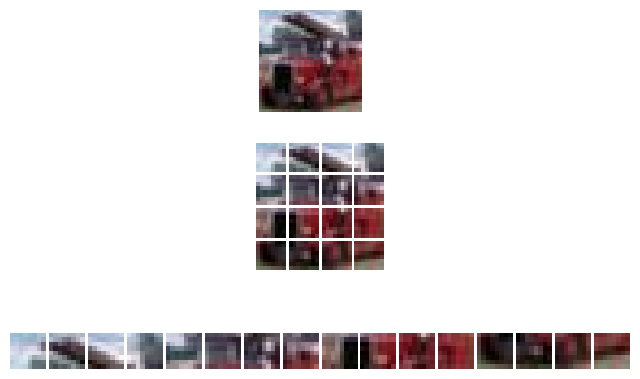

In [16]:
sample_img, sample_img_trans, sample_img_label, ch, img_size, slice_width, slices, slice_flatsize, batch_size = img_data(
    Im_tr_loader, 2)
print(f"Input Image Shape: {sample_img.size()}")
img_plot(sample_img, slice_width)
print(f"Flattened Image Shape: {sample_img_trans.size()}")


print("")
print("slice_flatsize",slice_flatsize)
slice_embed = slice_flatsize*4
print("slice_embed",slice_embed)

### Build the VIT Model : Embedding &rarr; Transformer Encoder &rarr; MLP_Head

In [17]:
class ImageEmbedding(nn.Module):

    def __init__(self, slice_input_size, slice_embed_size, img_slices, dropout_ratio=0.2):
        super().__init__()

        # Use FC layer to change the image flattened slice to embedding    
        self.img_to_embed = nn.Linear(slice_input_size, slice_embed_size)

        # cls: classification token is added to each image as an additional slice(patch),
        # it has the same embedding size as any slice in the image.
        # here I consider a single image, the batch size will be considered under the forward method
        # note that it will be trainable that's why I added (requires grad)
        self.cls_to_embed = nn.Parameter(torch.rand(1, slice_embed_size),requires_grad=True)

        # positional embedding: is added to each slice in the image (including the cls token),
        # it identifies the position of the slice (patch) inside the image.
        # here I consider a single image, the batch size will be considered under the forward method
        # note that it will be trainable that's why I added (requires grad)
        self.pos_to_embed = nn.Parameter(torch.rand(img_slices + 1, slice_embed_size), requires_grad=True)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, flattened_imgs):

        # b: is the number of images in the batch
        batch_size = flattened_imgs.size(0)

        # the input is a batch of images each has been sliced to patches and each slice
        # has been flattened. i.e. the shape of the input is:
        # [no. of images ,no. of slices per image, size of the flattened image slice]
        #
        img_embedding = self.img_to_embed(flattened_imgs)

        # repeat cls for all the images in the batch
        cls_embedding = self.cls_to_embed.repeat(batch_size, 1, 1)

        # we can repeat position for all the images in the batch, but it's not necessary
        # position_embedding = self.pos_to_embed.repeat(batch_size, 1, 1)
        position_embedding = self.pos_to_embed

        # Append the cls embedding to the beginning of the image slices
        img_embedding = torch.concat([cls_embedding, img_embedding], dim=1)
        img_and_pos_embedding = img_embedding + position_embedding
        
        embedding = self.dropout(img_and_pos_embedding)
        
        return embedding

In [18]:
embedding_layer = ImageEmbedding(slice_input_size=slice_flatsize,
                                 slice_embed_size=slice_embed,
                                 img_slices=slices,
                                 dropout_ratio=0.2)

embedding_output = embedding_layer(sample_img_batch)

print("Sample batch shape:  ", sample_img_batch.size())
print("Label of a sample image: ",sample_img_label)
print("")
print("Output Shape: ", embedding_output.size())
print("Output Gradient Function: ",embedding_output.grad_fn)

summary(model=embedding_layer,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])



Sample batch shape:   torch.Size([16, 16, 192])
Label of a sample image:  tensor([1., 0.], dtype=torch.float64)

Output Shape:  torch.Size([16, 17, 768])
Output Gradient Function:  <MulBackward0 object at 0x7fbd2e44fa30>


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ImageEmbedding (ImageEmbedding)          [16, 16, 192]        [16, 17, 768]        13,824               True
├─Linear (img_to_embed)                  [16, 16, 192]        [16, 16, 768]        148,224              True
├─Dropout (dropout)                      [16, 17, 768]        [16, 17, 768]        --                   --
Total params: 162,048
Trainable params: 162,048
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.37
Input size (MB): 0.20
Forward/backward pass size (MB): 1.57
Params size (MB): 0.59
Estimated Total Size (MB): 2.36

<style>
red { color: red }
yellow { color: yellow }
</style>

##### **<yellow> Query: </yellow>** The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.

##### **<yellow> Keys: </yellow>** For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is “offering”, or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.

##### **<yellow> Values: </yellow>** For each input element, we also have a value vector. This feature vector is the one we want to average over.

##### **<yellow> Score function: </yellow>** To rate which elements we want to pay attention to, we need to specify a score function . The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.

##### A word asks the same question to all words in the sequence using the ‘query’ vector. Similarly, it provides the same answer to all words using the ‘key’ vector. 

$$
\text { Attention }(Q, K, V)=\operatorname{Softmax}\left(\frac{Q K^{\top}}{\sqrt{d}}\right) V
$$
​

In [19]:

class MHA(nn.Module):
    def __init__(self, embed_dim: int, num_of_head: int = 12, Dropout=0.2) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.num_of_head = num_of_head
        self.depth = self.embed_dim // self.num_of_head
        self.Wq = nn.Linear(in_features=embed_dim, out_features=embed_dim)
        self.Wk = nn.Linear(in_features=embed_dim, out_features=embed_dim)
        self.Wv = nn.Linear(in_features=embed_dim, out_features=embed_dim)
        # self.dropout=nn.Dropout(p=Dropout)
        self.dropout = Dropout
        self.linear = nn.Linear(in_features=embed_dim, out_features=embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        Q = rearrange(q, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.depth)
        K = rearrange(k, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.depth)
        V = rearrange(v, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.depth)

        use_dropout = 0.0 if not self.training else self.dropout

        attention = F.scaled_dot_product_attention(
            Q, K, V, attn_mask=None, dropout_p=use_dropout, is_causal=True)
        # # Q(b h s d) . KT(b h d s) ==> b h s s
        # # qk = torch.matmul(q, k.transpose(-2, -1)) / (self.depth**0.5)
        # qk = torch.matmul(q, k.transpose(-2, -1)) / (self.embed_dim**0.5)

        # #  b h s s ==> b h s s
        # weight = F.softmax(qk, dim=1)
        # # weight_dropout=self.dropout(weight)

        # #weight(b h s s).V(b h s d) ==> attention (b h s d)
        # attention = torch.matmul(weight, v)
        # # attention = torch.matmul(weight_dropout, v)

        attention = rearrange(attention, 'b h s d -> b s (h d)')
        attention = self.linear(attention)
        return attention

In [20]:
# MHA_layer = MHA(d_in=embedding_output.size(2),
#                                  d_out=embedding_output.size(2),
#                                  num_heads=12,
#                                  block_size=embedding_output.size(1),
#                                  dropout=0.0
#                                  )

# MHA_output = MHA_layer(embedding_output)

# print("Input Shape:  ", embedding_output.size())
# print("Output Shape: ", MHA_output.size())

# summary(model=MHA_layer,
#         input_size=embedding_output.size(),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [21]:
class Encoder(nn.Module):

    def __init__(self, embed_size, num_heads, dropout=0.1):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.attention = MHA(embed_dim=embed_size,
                             num_of_head=num_heads,
                             Dropout=dropout)

        # Below I selected the hidden size of the feed forward = 4 * embed size
        self.feed_forward = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, 4 * embed_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4 * embed_size, embed_size),
            nn.Dropout(dropout))

    def forward(self, input):
        normalized_input = self.norm1(input)

        attn = self.attention(normalized_input)

        attn_and_input = input + attn

        normalized_attn = self.norm2(attn_and_input)

        output = attn + self.feed_forward(normalized_attn)

        return output

In [22]:
# encoder_layer = Encoder(embed_size=slice_flatsize, num_heads=12, dropout=0.1)
# encoder_output = encoder_layer(embedding_output)

# print("Output Shape: ", encoder_output.size())

# summary(model=encoder_layer,
#         input_size=embedding_output.size(),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])


In [23]:
class VIT(nn.Module):
    def __init__(self,
                 slice_input_size,
                 slice_embed_size,
                 img_slices,
                 num_classes,
                 num_heads,
                 num_encoders=1,
                 emb_dropout=0.1,
                 enc_dropout=0.1):
        super().__init__()

        self.embedding = ImageEmbedding(
            slice_input_size=slice_input_size,
            slice_embed_size=slice_embed_size,
            img_slices=img_slices,
            dropout_ratio=emb_dropout)

        self.encoders = nn.Sequential(
            *[Encoder(slice_embed_size, num_heads, dropout=enc_dropout) for _ in range(num_encoders)])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(slice_embed_size),
            nn.Linear(slice_embed_size, num_classes))

    def forward(self, flattened_img):
        emb = self.embedding(flattened_img)
        attn = self.encoders(emb)
        output = self.mlp_head(attn[:, 0])

        return output

#### Define the Model Hyper-parameters Hereunder:

In [24]:
vit_model = VIT(slice_input_size=slice_flatsize,
                slice_embed_size=slice_embed,
                img_slices=slices,
                num_classes=2,
                num_heads=12,
                num_encoders=2,
                emb_dropout=0.1,
                enc_dropout=0.1)

vit_output = vit_model(sample_img_batch)

print("Input Shape: ", sample_img_batch.size())
print("Output Shape: ", vit_output.size())

summary(model=vit_model,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([16, 16, 192])
Output Shape:  torch.Size([16, 2])


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                     [16, 16, 192]        [16, 2]              --                   True
├─ImageEmbedding (embedding)                  [16, 16, 192]        [16, 17, 768]        13,824               True
│    └─Linear (img_to_embed)                  [16, 16, 192]        [16, 16, 768]        148,224              True
│    └─Dropout (dropout)                      [16, 17, 768]        [16, 17, 768]        --                   --
├─Sequential (encoders)                       [16, 17, 768]        [16, 17, 768]        --                   True
│    └─Encoder (0)                            [16, 17, 768]        [16, 17, 768]        --                   True
│    │    └─LayerNorm (norm1)                 [16, 17, 768]        [16, 17, 768]        1,536                True
│    │    └─MHA (attention)                   [16, 17, 768]        [16, 17, 768]     

In [25]:
vit_epochs = 200         # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)

In [26]:
# Betas used for Adam in paper are 0.9 and 0.999, which are the default in PyTorch
optimizer = Adam(vit_model.parameters(), lr=base_lr, weight_decay=weight_decay)
loss_criterion = CrossEntropyLoss() # returns the mean loss for the batch
# scheduler = lr_scheduler.LinearLR(optimizer)

In [27]:
model_state_path="../weights/vit5/"

# saved_model = vit_model()
# saved_model.load_state_dict(torch.load(model_state_path))

In [28]:
tr_loss_history = [1000]
tr_accuracy_history = [0]
val_loss_history = [1000]
val_accuracy_history = [0]

vit_model.to(device)

for epoch in range(vit_epochs):

    # Training Loop
    vit_model.train(True)

    accumulated_tr_loss = 0
    accumulated_tr_accuracy = 0
    accumulated_val_loss = 0
    accumulated_val_accuracy = 0

    loop = tqdm(enumerate(Im_tr_loader), total=len(Im_tr_loader))
    for batch, (_, inputs, targets) in loop:

        # Put inputs and labels in device cuda
        tr_images = inputs.to(device)
        sample_img_labels = targets.to(device)

        # Forward Path
        tr_outputs = vit_model(tr_images)#.squeeze(1)
        # print(sample_img_labels.size())
        # print(tr_outputs.size())

        loss = loss_criterion(tr_outputs,sample_img_labels)

        accumulated_tr_loss += loss.detach().cpu().item()#loss.item()
        accumulated_tr_accuracy += (sample_img_labels.argmax(dim=-1) == tr_outputs.argmax(dim=-1)).sum().item()/sample_img_labels.size(0)
        
        avg_tr_loss = accumulated_tr_loss / (batch+1)
        avg_tr_accuracy = 100*accumulated_tr_accuracy / (batch+1)
        # avg_tr_loss = accumulated_tr_loss / len(Im_tr_loader)
        # avg_tr_accuracy = 100*accumulated_tr_accuracy / len(Im_tr_loader)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Backward path (Gradient)
        loss.backward()

        # Optimizer(Adam) Step
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{vit_epochs}]")
        loop.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)
    
    tr_loss_history.append(avg_tr_loss)
    tr_accuracy_history.append(avg_tr_accuracy)

    # scheduler.step()


# Validation Loop
    vit_model.eval()

    with torch.no_grad():

        for batch, (_, inputs, targets) in enumerate(Im_val_loader):

            # Put inputs and labels in device cuda
            val_images = inputs.to(device)
            val_labels = targets.to(device)

            val_outputs = vit_model(val_images)#.squeeze(1)

            loss = loss_criterion(val_outputs,val_labels)

            accumulated_val_loss += loss.detach().cpu().item() #loss.item()
            accumulated_val_accuracy += (val_labels.argmax(dim=-1) == val_outputs.argmax(dim=-1)).sum().item()/val_labels.size(0)

            avg_val_loss = accumulated_val_loss / (batch+1)
            avg_val_accuracy = 100*accumulated_val_accuracy / (batch+1)
            # avg_val_loss = accumulated_val_loss / len(Im_val_loader)
            # avg_val_accuracy = 100*accumulated_val_accuracy / len(Im_val_loader)

        
        best_val_loss=min(val_loss_history)
        if avg_val_loss < best_val_loss:
            torch.save(vit_model.state_dict(), model_state_path+f'epoch_{epoch}')

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_accuracy)

        print(f'Validation loss: {avg_val_loss:.2f} | Validation accuracy: {avg_val_accuracy:.2f}')
        print("------------------------------------------------------------------------------------")

Epoch [1/200]: 100%|██████████| 6000/6000 [01:02<00:00, 95.26it/s, acc=50.1, loss=nan]  


Validation loss: nan | Validation accuracy: 50.00
------------------------------------------------------------------------------------


Epoch [2/200]:  17%|█▋        | 1015/6000 [00:10<00:52, 94.13it/s, acc=50.3, loss=nan]


KeyboardInterrupt: 

In [ ]:
for param_tensor in vit_model.state_dict():
    print(param_tensor, "\t", vit_model.state_dict()[param_tensor].size())

In [ ]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(tr_loss_history )), tr_loss_history , label='Train Loss')
axs[0].plot(range(len(tr_accuracy_history)), tr_accuracy_history, label='Validation Loss')
axs[1].plot(range(len(val_loss_history)), val_loss_history, label='Train Accuracy')
axs[1].plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
axs[0].set_ylim([0,70])
axs[1].set_ylim([0,70])
axs[0].legend()
axs[1].legend()
plt.show()